# 🛒 Market Basket Analysis with Apriori Algorithm

This notebook explores how we can uncover useful product combinations using the Apriori algorithm. We'll be analyzing a dataset of grocery transactions to find patterns and make item recommendations.

* ## 1. Import Libraries
Here, we load all the necessary Python libraries.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")

* ## 2. Load and Explore the Dataset

In [16]:
data = pd.read_csv('Groceries_dataset.csv')
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


* ## 3. Top 20 Most Purchased Items
Let's see which items are most frequently bought.

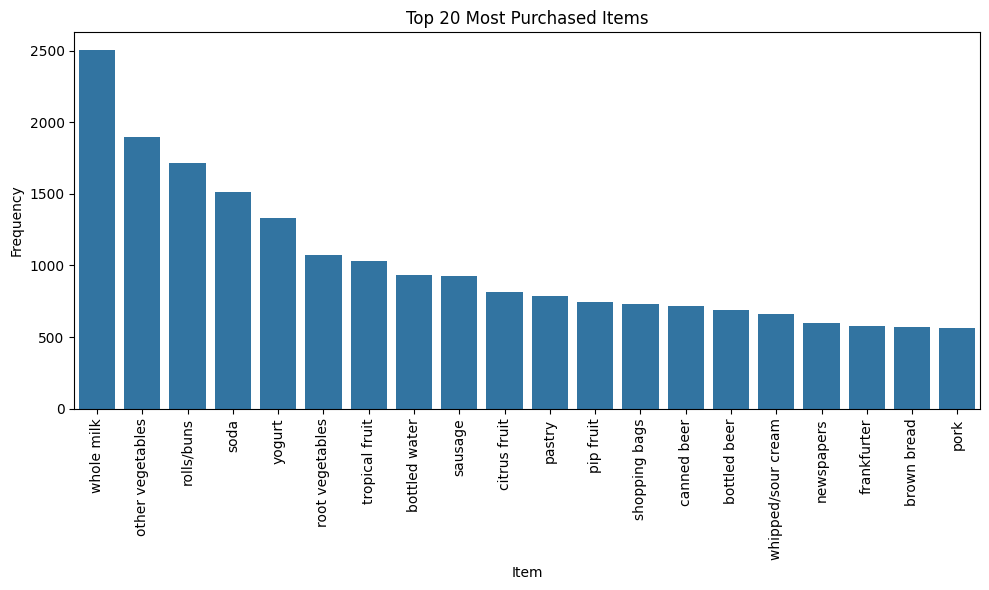

In [17]:
top_items = data['itemDescription'].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_items.index, y=top_items.values)
plt.title('Top 20 Most Purchased Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

* ## 4. Data Preprocessing
We prepare the data for the Apriori algorithm by turning it into a format it can work with.

In [18]:
data['Quantity'] = 1

In [19]:
basket = data.groupby(['Member_number', 'itemDescription'])['Quantity'].sum().unstack().fillna(0)

In [20]:

def encode(x):
    if x <= 0:
        return 0
    else:
        return 1


In [21]:
basket = basket.applymap(encode)

* ## 5. Applying the Apriori Algorithm
Now we find frequently bought itemsets.

In [22]:
frequent_itemsets = apriori(basket, min_support=0.06, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head()

,support,itemsets
45,0.458184,(whole milk)
30,0.376603,(other vegetables)
34,0.349666,(rolls/buns)
39,0.313494,(soda)
46,0.282966,(yogurt)


* ## 6. Generate Association Rules
These rules help us understand what items are often bought together.

In [23]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules = rules.sort_values(by='confidence', ascending=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
140,"(other vegetables, yogurt)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,1.0,0.016704,1.344507,0.264348,0.141772,0.256233,0.376895
152,"(rolls/buns, yogurt)",(whole milk),0.111339,0.458184,0.065931,0.592166,1.292420,1.0,0.014917,1.328521,0.254605,0.130922,0.247283,0.368031
128,"(rolls/buns, other vegetables)",(whole milk),0.146742,0.458184,0.082093,0.559441,1.220996,1.0,0.014859,1.229837,0.212124,0.157017,0.186884,0.369306
134,"(soda, other vegetables)",(whole milk),0.124166,0.458184,0.069266,0.557851,1.217528,1.0,0.012375,1.225416,0.203992,0.135000,0.183951,0.354514
146,"(rolls/buns, soda)",(whole milk),0.119805,0.458184,0.065162,0.543897,1.187072,1.0,0.010269,1.187926,0.179041,0.127064,0.158197,0.343057


* ## 7. Filter Strong Rules
We’ll keep only rules with high confidence and lift.

In [24]:
confidence_threshold = 0.4
lift_threshold = 1
strong_rules = rules[(rules['confidence'] > confidence_threshold) & (rules['lift'] > lift_threshold)]
strong_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
140,"(other vegetables, yogurt)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,1.0,0.016704,1.344507,0.264348,0.141772,0.256233,0.376895
152,"(rolls/buns, yogurt)",(whole milk),0.111339,0.458184,0.065931,0.592166,1.292420,1.0,0.014917,1.328521,0.254605,0.130922,0.247283,0.368031
128,"(rolls/buns, other vegetables)",(whole milk),0.146742,0.458184,0.082093,0.559441,1.220996,1.0,0.014859,1.229837,0.212124,0.157017,0.186884,0.369306
134,"(soda, other vegetables)",(whole milk),0.124166,0.458184,0.069266,0.557851,1.217528,1.0,0.012375,1.225416,0.203992,0.135000,0.183951,0.354514
146,"(rolls/buns, soda)",(whole milk),0.119805,0.458184,0.065162,0.543897,1.187072,1.0,0.010269,1.187926,0.179041,0.127064,0.158197,0.343057


* ## 8. Item Recommendation Function
This function will suggest items often bought with a given product.

In [25]:

def recommend_items(items, confidence_threshold=0.4, lift_threshold=1):
    """
    Recommends items that are often bought with the given item(s).
    items: a string (single item) or list of items
    Returns: list of recommended items
    """
    if isinstance(items, str):
        items = [items]

    filtered = rules[
        (rules['antecedents'].apply(lambda x: any(i in x for i in items))) &
        (rules['confidence'] > confidence_threshold) &
        (rules['lift'] > lift_threshold)
    ]

    recommended = filtered['consequents'].apply(lambda x: list(x)).explode().unique()
    recommended = [item for item in recommended if item not in items]

    print("Recommended items (consequents):")
    return list(recommended)


* ## 9. Example Recommendations

In [26]:
recommend_items("whole milk")

Recommended items (consequents):


['other vegetables', 'rolls/buns']

In [27]:
recommend_items(["rolls/buns", "yogurt"])

Recommended items (consequents):


['whole milk', 'other vegetables']

In [28]:
recommend_items("yogurt")

Recommended items (consequents):


['whole milk', 'other vegetables', 'rolls/buns']

* ## Conclusion

We used the Apriori algorithm to uncover relationships between grocery items and built a basic recommender. This approach can be used in retail for promotions, shelf placement, and bundling strategies.